In [1]:
import joblib

# Preprocessing
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Torch-related
import torch
from pytorch_model_summary import summary

# Custom defined
from libs.raw_data import *
from libs.dataset import *
from architecture.architecture import *

device = torch.device("cuda")

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedba

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
class LogScaler(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        return np.log1p(x)

In [3]:
is_test_mode = False
mode = "pre-train"
mode = "fine_tuning"

# Raw data
is_prep_data_exist = True

# Data loader
MIN_MEANINGFUL_SEQ_LEN = 100
MAX_SEQ_LEN = 100
PRED_LEN = 50

modality_info = {
    "group": ["article_id", "sales_channel_id"],
    "target": ["sales"],
    "temporal": ["day", "dow", "month", "holiday", "price"],
    "img": ["img_path"],
    "nlp": []
}
processing_info = {
    "scaling_cols": {"sales": StandardScaler, "price": StandardScaler},
    "embedding_cols": ["day", "dow", "month", "holiday"],
    "img_cols": ["img_path"],
    "nlp_cols": []
}

# Model
batch_size = 16
target_batch_size = 16
num_accm = int(target_batch_size//batch_size)
nhead = 6
dropout = 0.1
patch_size = 16

d_model = {"encoder":nhead*64, "decoder":nhead*32}
d_ff = {"encoder":nhead*64, "decoder":nhead*32}
num_layers = {"encoder":3, "decoder":3}
remain_rto = {"temporal":1., "img":1., "nlp":1.}

In [4]:
data_info = DataInfo(modality_info, processing_info)
df_prep = get_raw_data(is_test_mode, is_prep_data_exist)

df_valid = df_prep[(df_prep["meaningful_size"] >= MIN_MEANINGFUL_SEQ_LEN)
                    &(df_prep["time_idx"] <= MAX_SEQ_LEN-1+PRED_LEN)
                    &(~pd.isna(df_prep["detail_desc"]))]
df_valid = df_valid[df_valid["perceived_colour_value_name"].isin(["Light", "Bright"])]

In [5]:
path = './saved_model_epoch2_2024-05-06 01:00:07.310100'

label_encoder_dict = joblib.load("./src/label_encoder_dict.pkl")
mbae = MaskedBlockAutoEncoder(data_info, label_encoder_dict,
                            d_model, num_layers, nhead, d_ff, dropout, "gelu",
                            patch_size)
mbae.load_state_dict(torch.load(path))
mbae_encoder = mbae.mbae_encoder
# mbae_encoder.to(device)
""

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


''

In [6]:
from tqdm import tqdm; tqdm.pandas()

# Sklearn-related
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

# Torch-related
import torch
from transformers import AutoImageProcessor, AutoTokenizer
from PIL import Image

# transform_img = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
transform_img = v2.Compose([
    v2.Resize((224,224)),
    v2.ToTensor(),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization parameters for ImageNet
    v2.Normalize(mean=[0.7623358, 0.74334157, 0.738284], std=[0.27400097, 0.2852157, 0.28155997]),
])
augmentation = v2.Compose([
    # v2.RandomHorizontalFlip(),
    # v2.ColorJitter(contrast=(2,2)),
    # v2.RandomRotation(45),
    v2.RandomResizedCrop(224),
    # v2.Resize((224,224)),
    v2.ToTensor(),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization parameters for ImageNet
    v2.Normalize(mean=[0.7623358, 0.74334157, 0.738284], std=[0.27400097, 0.2852157, 0.28155997]),
    # v2.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1)),
])

class ValidDataset(torch.utils.data.Dataset):
    def __init__(self, data, data_info, remain_rto, label_encoder_dict):
        super().__init__()
        self.data_info, self.remain_rto = data_info, remain_rto
        self.tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

        # Fit label encoder
        self.label_encoder_dict = label_encoder_dict

        # Iterate data
        data_li = []
        data.groupby(self.data_info.modality_info["group"]).progress_apply(lambda x: data_li.append(x))
        self.dataset = tuple(data_li)

    def transform_label_encoder(self, data):
        result_dict = {}
        embedding_cols = self.data_info.processing_info["embedding_cols"]
        for col in embedding_cols:
            result_dict[col] = self.label_encoder_dict[col].transform(data[col].values)
        return result_dict
    
    def scale_data(self, data):
        result_dict = {}
        scaling_cols = self.data_info.processing_info["scaling_cols"]
        for col, scaler in scaling_cols.items():
            scaler = scaler()
            result_dict[col] = scaler.fit_transform(data[col].values.reshape(-1,1))
            result_dict[f"{col}_scaler"] = scaler
        return result_dict

    def apply_nlp_remain(self, data):
        result_dict = {}
        nlp_cols = self.data_info.modality_info["nlp"]
        remain_rto = self.remain_rto["nlp"]

        for col in nlp_cols:
            nlp_data = set(data[col].values); assert len(nlp_data) == 1
            total_token = self.tokenizer(next(iter(nlp_data)), return_tensors="np")["input_ids"].squeeze()
            
            # Split global token and valid token
            global_token = total_token[:1]
            valid_token = total_token[1:]
            
            # Get remain/masked/revert indices
            valid_token_shape = valid_token.shape; assert len(valid_token_shape)==1
            
            num_remain = int(valid_token_shape[0] * remain_rto)
            noise = np.random.rand(valid_token_shape[0])
            shuffle_idx = np.argsort(noise)
            
            remain_idx = shuffle_idx[:num_remain]
            masked_idx = shuffle_idx[num_remain:]
            revert_idx = np.argsort(shuffle_idx)
            
            remain_padding_mask = np.ones(remain_idx.shape[0]+1)
            masked_padding_mask = np.ones(masked_idx.shape[0]+1)
            revert_padding_mask = np.ones(revert_idx.shape[0]+1)

            result_dict.update({f"{col}":total_token, f"{col}_raw":nlp_data,
                                f"{col}_remain_idx":remain_idx, f"{col}_masked_idx":masked_idx, f"{col}_revert_idx":revert_idx,
                                f"{col}_remain_padding_mask":remain_padding_mask, f"{col}_masked_padding_mask":masked_padding_mask, f"{col}_revert_padding_mask":revert_padding_mask})

        return result_dict

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        result_dict = {}
        data = self.dataset[idx]
        
        # Laben encode and scale data
        embedding_cols = self.transform_label_encoder(data)
        scaling_cols = self.scale_data(data)
        result_dict.update(**embedding_cols, **scaling_cols)
        
        # Temporal forecast/padding mask
        target_col = self.data_info.modality_info["target"]
        target_fcst_mask = np.ones(data[target_col].shape).squeeze()
        target_fcst_mask[-PRED_LEN:] = 0
        
        temporal_padding_mask  = np.ones(data[target_col].shape).squeeze()
        result_dict.update({"target_fcst_mask":target_fcst_mask, "temporal_padding_mask":temporal_padding_mask})

        # Img
        img_cols = self.data_info.modality_info["img"]
        for col in img_cols:
            img_path = set(data[col].values); assert len(img_path) == 1
            img_raw = Image.open(next(iter(img_path))).convert("RGB")
            result_dict[f"{col}_raw"] = img_raw
        
        # Nlp
        nlp_result_dict = self.apply_nlp_remain(data)
        result_dict.update(nlp_result_dict)

        return result_dict

def valid_collate_fn(batch_li, data_info):
    result_dict = {}
    # Temporal
    target_temporal_cols = data_info.modality_info["target"] + data_info.modality_info["temporal"]
    for col in target_temporal_cols:
        tensor_type = torch.int if col in data_info.processing_info["embedding_cols"] else torch.float
        data = [torch.from_numpy(batch[col]).to(tensor_type) for batch in batch_li]
        result_dict[col] = torch.nn.utils.rnn.pad_sequence(data, batch_first=True)
    ### Temporal masks
    target_fcst_mask = [torch.from_numpy(batch["target_fcst_mask"]) for batch in batch_li]
    temporal_padding_mask = [torch.from_numpy(batch["temporal_padding_mask"]) for batch in batch_li]
    
    result_dict["target_fcst_mask"] = torch.nn.utils.rnn.pad_sequence(target_fcst_mask, batch_first=True)
    result_dict["temporal_padding_mask"] = torch.nn.utils.rnn.pad_sequence(temporal_padding_mask, batch_first=True)

    # Img
    img_cols = data_info.modality_info["img"]
    for col in img_cols:
        img_raw = [batch[f"{col}_raw"] for batch in batch_li]
        img_data = torch.stack([augmentation(i) for i in img_raw], dim=0)

        result_dict[f"{col}_raw"] = torch.stack([transform_img(i) for i in img_raw], dim=0)
        result_dict[f"{col}"] = img_data
    
    # Nlp
    nlp_cols = data_info.modality_info["nlp"]
    for col in nlp_cols:
        data = [torch.from_numpy(batch[col]).to(torch.int) for batch in batch_li]
        data_remain_idx = [torch.from_numpy(batch[f"{col}_remain_idx"]).to(torch.int64) for batch in batch_li]
        data_masked_idx = [torch.from_numpy(batch[f"{col}_masked_idx"]).to(torch.int64) for batch in batch_li]
        data_revert_idx = [torch.from_numpy(batch[f"{col}_revert_idx"]).to(torch.int64) for batch in batch_li]
        data_remain_padding_mask = [torch.from_numpy(batch[f"{col}_remain_padding_mask"]).to(tensor_type) for batch in batch_li]
        data_masked_padding_mask = [torch.from_numpy(batch[f"{col}_masked_padding_mask"]).to(tensor_type) for batch in batch_li]
        data_revert_padding_mask = [torch.from_numpy(batch[f"{col}_revert_padding_mask"]).to(tensor_type) for batch in batch_li]

        result_dict[col] = torch.nn.utils.rnn.pad_sequence(data, batch_first=True)
        result_dict[f"{col}_remain_idx"] = torch.nn.utils.rnn.pad_sequence(data_remain_idx, batch_first=True)
        result_dict[f"{col}_masked_idx"] = torch.nn.utils.rnn.pad_sequence(data_masked_idx, batch_first=True)
        result_dict[f"{col}_revert_idx"] = torch.nn.utils.rnn.pad_sequence(data_revert_idx, batch_first=True)
        result_dict[f"{col}_remain_padding_mask"] = torch.nn.utils.rnn.pad_sequence(data_remain_padding_mask, batch_first=True)
        result_dict[f"{col}_masked_padding_mask"] = torch.nn.utils.rnn.pad_sequence(data_masked_padding_mask, batch_first=True)
        result_dict[f"{col}_revert_padding_mask"] = torch.nn.utils.rnn.pad_sequence(data_revert_padding_mask, batch_first=True)

        result_dict[f"{col}_raw"] = [batch[f"{col}_raw"] for batch in batch_li]

    return result_dict

1==1

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


True

In [7]:
valid_dataset = ValidDataset(df_valid, data_info, remain_rto, label_encoder_dict)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: valid_collate_fn(x, data_info), pin_memory=True, num_workers=16, prefetch_factor=4)
for valid_data in valid_dataloader:
    [print(key, val.shape) for key, val in valid_data.items() if "scaler" not in key and "raw" not in key]
    break

100%|██████████| 5377/5377 [00:00<00:00, 20802.57it/s]


sales torch.Size([16, 150, 1])
day torch.Size([16, 150])
dow torch.Size([16, 150])
month torch.Size([16, 150])
holiday torch.Size([16, 150])
price torch.Size([16, 150, 1])
target_fcst_mask torch.Size([16, 150])
temporal_padding_mask torch.Size([16, 150])
img_path torch.Size([16, 3, 224, 224])


In [13]:
class GlobalDecoder(torch.nn.Module):
    def __init__(self, temporal_cols, img_cols, nlp_cols, d_model, nhead, d_ff, dropout, activation, num_layers):
        super().__init__()
        self.temporal_cols, self.img_cols, self.nlp_cols = temporal_cols, img_cols, nlp_cols
        self.decoder_layer = torch.nn.ModuleList([DecoderLayer(d_model, nhead, d_ff, dropout, activation) for _ in range(num_layers)])
    
    def forward(self, data_dict, padding_mask_dict, device):
        target = "sales"
        tgt_dict, tgt_key_padding_mask_dict, memory_dict, memory_key_padding_mask_dict= self.get_tgt_memory(data_dict, padding_mask_dict, device, target)
        for mod in self.decoder_layer:
                tgt_dict, self_attn_weight, cross_attn_weight_dict, _ = mod(tgt_dict, memory_dict, tgt_key_padding_mask_dict, memory_key_padding_mask_dict, fine_tuning=True)
        decoding_dict = {target:tgt_dict["temporal"]}
        return decoding_dict, self_attn_weight, cross_attn_weight_dict
    
    def get_tgt_memory(self, data_dict, padding_mask_dict, device, target):
        tgt_dict, tgt_key_padding_mask_dict, memory_dict, memory_key_padding_mask_dict = {}, {}, {}, {}
        modality = "temporal"

        # Obtain target
        tgt_dict[modality] = data_dict[target]
    
        tgt_key_padding_mask_dict[modality] = padding_mask_dict["temporal_padding_mask"]
        assert tgt_dict[modality].shape[:-1] == tgt_key_padding_mask_dict[modality].shape
        
        # Memory
        ### Temporal memory
        temporal_memory_li = [val for key, val in data_dict.items() if key in ["global"]+self.temporal_cols]
        # temporal_memory_li = [val for key, val in data_dict.items() if key!= ["global"] and key in ["global"] + self.temporal_cols]
        temporal_memory_block = torch.stack(temporal_memory_li, dim=-2)
        memory_dict["temporal"] = temporal_memory_block

        num_modality = temporal_memory_block.shape[-2]

        temporal_key_padding_mask = padding_mask_dict["temporal_padding_mask"].unsqueeze(-1).repeat(1, 1, num_modality)
        # temporal_key_padding_mask = torch.ones(padding_mask_dict["temporal_padding_mask"].shape).unsqueeze(-1).repeat(1, 1, num_modality).to(device)
        temporal_key_padding_mask[:, :, 1] = padding_mask_dict["target_fcst_mask"]
        # temporal_key_padding_mask[:, :, 0] = padding_mask_dict["target_fcst_mask"]

        memory_key_padding_mask_dict["temporal"] = temporal_key_padding_mask
        assert temporal_memory_block.shape[:-1] == temporal_key_padding_mask.shape

        ### Static memory
        static_memory_li = [val for key, val in data_dict.items() if key in self.img_cols+self.nlp_cols]
        if len(static_memory_li) > 0:
            static_memory = torch.cat(static_memory_li, dim=1)
            memory_dict["static"] = static_memory
            
            static_key_padding_mask_li = [padding_mask_dict[f"{key}_revert_padding_mask"] for key in data_dict.keys() if key in self.img_cols+self.nlp_cols]
            static_key_padding_mask = torch.cat(static_key_padding_mask_li, dim=1)
            memory_key_padding_mask_dict["static"] = static_key_padding_mask
            assert static_memory.shape[:-1] == static_key_padding_mask.shape

        return tgt_dict, tgt_key_padding_mask_dict, memory_dict, memory_key_padding_mask_dict


In [14]:
class ForecasterDecoder(torch.nn.Module):
    def __init__(self, temporal_cols, img_cols, nlp_cols,\
                        d_model_from, d_model, num_layers, nhead, d_ff, dropout, activation):
        super().__init__()
        self.temporal_cols, self.img_cols, self.nlp_cols = temporal_cols, img_cols, nlp_cols
        # 8. Decoding
        self.global_decoder = GlobalDecoder(temporal_cols, img_cols, nlp_cols, d_model, nhead, d_ff, dropout, activation, num_layers)
        self.norm = torch.nn.LayerNorm(d_model)
        # 9. Output
        self.output = Output(data_info, d_model, nhead, d_ff, dropout, activation, num_layers, label_encoder_dict, temporal_cols, img_cols, nlp_cols, patch_size)
    
    def forward(self, posmod_emb_dict,
                    idx_dict, padding_mask_dict):
        # 8. Decoding
        decoding_dict, self_attn_weight, cross_attn_weight_dict = self.global_decoder(posmod_emb_dict, padding_mask_dict, device)

        # 9. Output
        output_dict = self.output(decoding_dict, padding_mask_dict)

        return output_dict["sales"], self_attn_weight, cross_attn_weight_dict

In [15]:
# num_layers = {"encoder":4, "decoder":1}
class Forecaster(torch.nn.Module):
    def __init__(self, data_info, mbae_encoder,\
                    d_model, num_layers, nhead, d_ff, dropout, activation):
        super().__init__()
        temporal_cols, img_cols, nlp_cols = self.define_col_modalities(data_info)
        self.temporal_cols, self.img_cols, self.nlp_cols = temporal_cols, img_cols, nlp_cols
        self.mbae_encoder = mbae_encoder
        self.forecaster_decoder = ForecasterDecoder(["global"] + temporal_cols, img_cols, nlp_cols, d_model["encoder"], d_model["decoder"], num_layers["decoder"], nhead, d_ff["decoder"], dropout, activation)
        
        self.encoder = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(d_model["decoder"], nhead, d_ff["decoder"], dropout, activation, batch_first=True, norm_first=True), num_layers["decoder"])
        self.linear = torch.nn.Linear(d_model["decoder"], 1)
    
    def forward(self, data_input, remain_rto, device):
        data_input["sales"] = torch.where(data_input["target_fcst_mask"].unsqueeze(-1)==1, data_input["sales"], 0)
        posmod_emb_dict,\
                encoding_weight_dict, data_dict, idx_dict, padding_mask_dict = self.mbae_encoder(data_input, remain_rto, device)
        
        decoding, self_attn_weight, cross_attn_weight_dict = self.forecaster_decoder(posmod_emb_dict,\
                                                                                    idx_dict, padding_mask_dict)
        
        # decoding = self.encoder(posmod_emb_dict["global"], src_key_padding_mask=torch.where(data_input["temporal_padding_mask"]==1, 0, -torch.inf).to(device))
        # decoding = self.linear(decoding)
        # self_attn_weight = None
        # print(encoding_weight_dict.shape)
        # raise
        # encoding_weight_dict["temporal"] = encoding_weight_dict["temporal"][:, :, :, 0, :]
    
        return decoding, self_attn_weight, cross_attn_weight_dict, data_dict, idx_dict, padding_mask_dict
        # return decoding, self_attn_weight, encoding_weight_dict, data_dict, idx_dict, padding_mask_dict
    
    def define_col_modalities(self, data_info):
        temporal_cols = data_info.modality_info["target"] + data_info.modality_info["temporal"]
        img_cols = data_info.modality_info["img"]
        nlp_cols = data_info.modality_info["nlp"]

        return temporal_cols, img_cols, nlp_cols


model = Forecaster(data_info, mbae_encoder,\
                    d_model, num_layers, nhead, d_ff, dropout, "gelu")
model.to(device)
# summary(model, valid_data, remain_rto, device, show_parent_layers=True, print_summary=True)
""


''

In [16]:
# for name, param in model.named_parameters():
#     # if "img_model" in name:
#     #     param.requires_grad = False
#     # elif "nlp_model" in name:
#     #     param.requires_grad = False
    
#     if "mbae_encoder" in name:
#         param.requires_grad = False

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


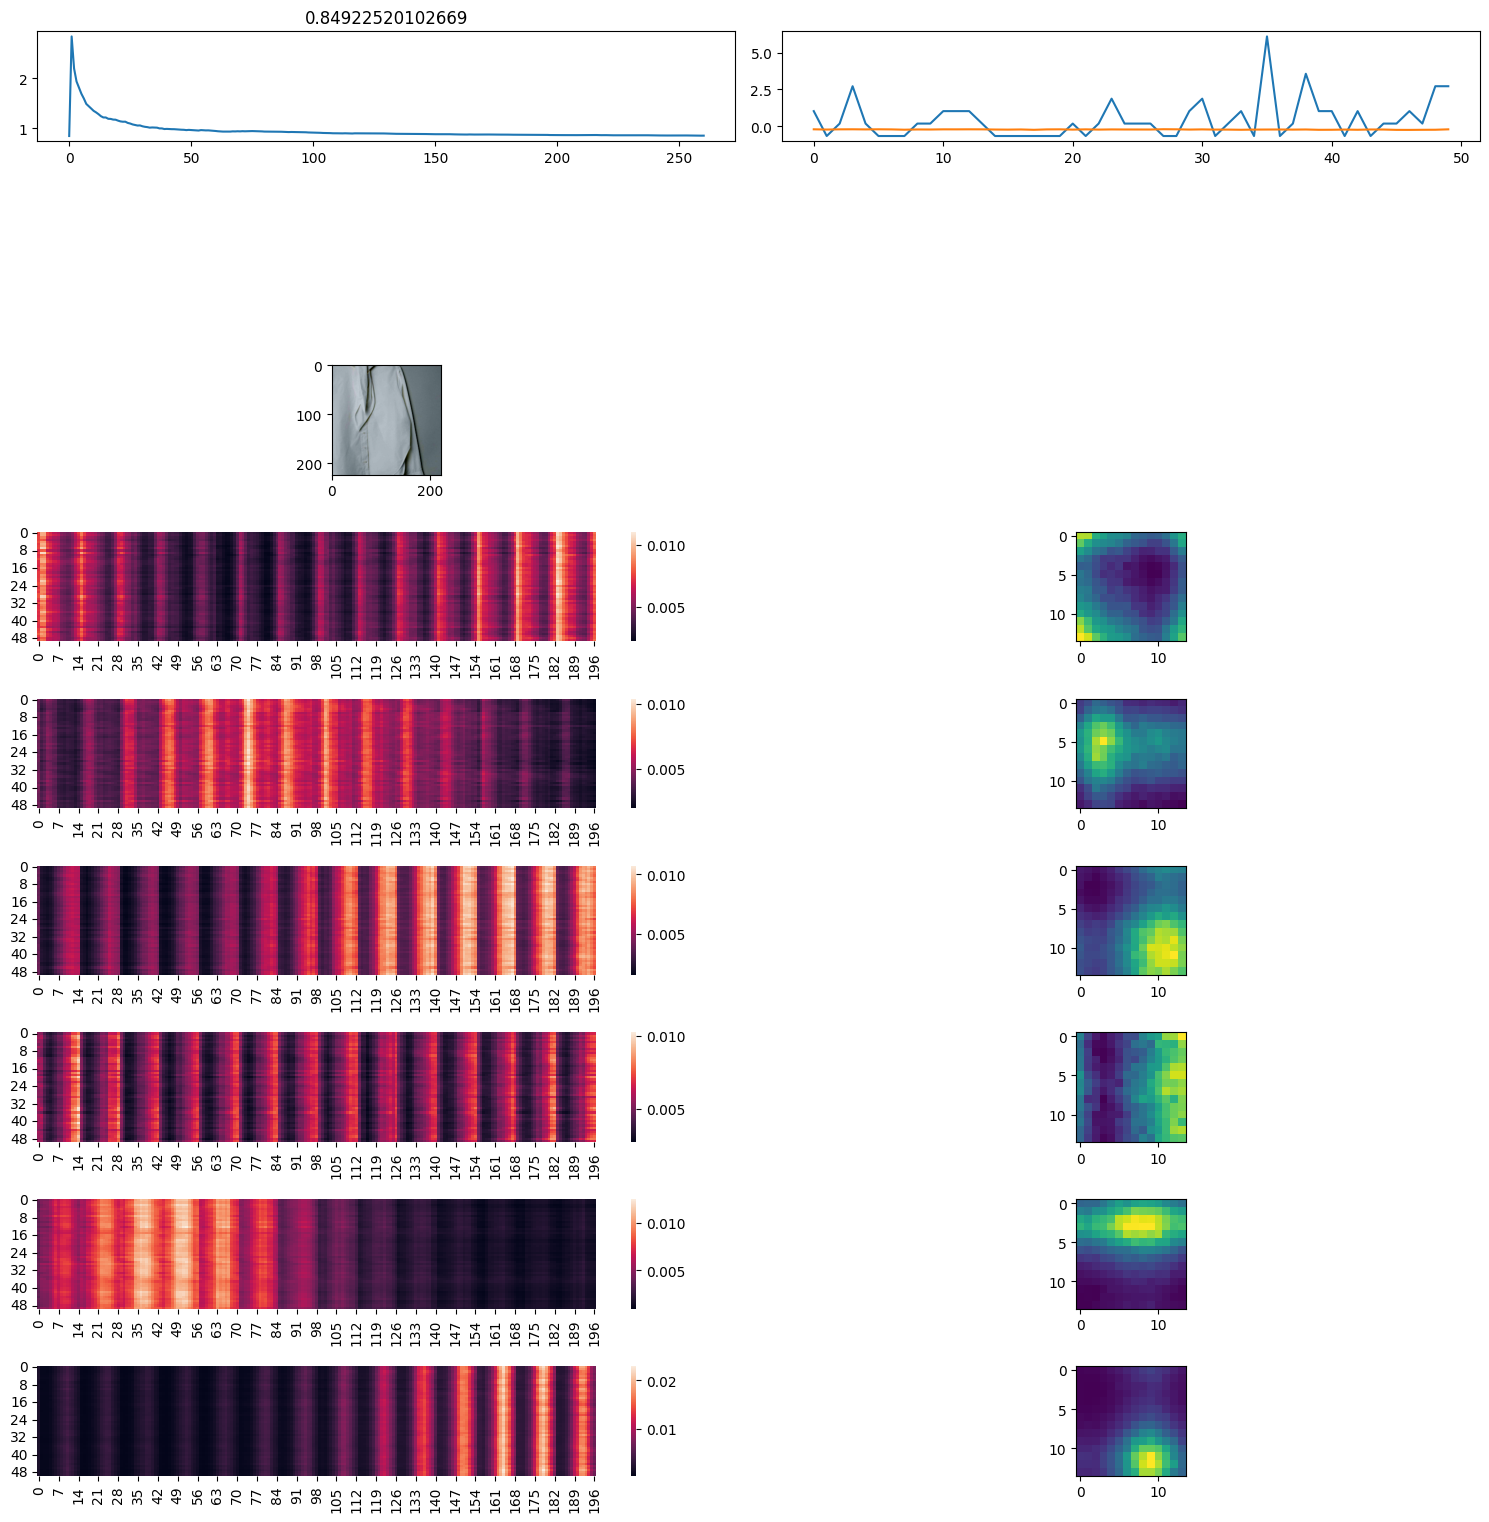

 79%|███████▉  | 267/337 [03:18<00:52,  1.34it/s]

In [17]:
from tqdm import tqdm; tqdm.pandas()
from collections import defaultdict
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
mse_loss = torch.nn.MSELoss(reduction="none")
ce_loss = torch.nn.CrossEntropyLoss(reduction="none")

import copy

def train(e, model):
    pbar = tqdm(valid_dataloader)
    loss_li, mean_loss_li = [], []
    accm_idx = 0

    for n, data in enumerate(pbar):
        # Train
        optimizer.zero_grad()
        model.train()
        output, self_attn_weight, cross_attn_weight_dict, data_dict, idx_dict, padding_mask_dict = model(copy.deepcopy(data), remain_rto, device)

        loss = mse_loss(output.squeeze(), data["sales"].to(device).squeeze())
        mask = torch.where((padding_mask_dict["temporal_padding_mask"].squeeze()==1)&(padding_mask_dict["target_fcst_mask"].squeeze()==0), 1, 0)

        loss *= mask
        loss = loss.sum() / mask.sum()
        loss_li.append(loss.item())
        mean_loss_li.append(np.array(loss_li).mean())
        
        accm_idx += 1
        (loss/accm_idx).backward()
        
        if accm_idx == num_accm:
            optimizer.step()
            accm_idx = 0

        # Plot
        if n % 20 == 0:
            nrows, ncols, idx = 30, 2, 0
            plt.figure(figsize=(15, 50))
            clear_output(wait=True)
            
            # Loss
            plt.subplot(nrows, ncols, 1)
            plt.plot(mean_loss_li)
            plt.title(mean_loss_li[-1])

            # Sample
            plt.subplot(nrows, ncols, 2)
            pred = torch.where(mask==1, output.squeeze(), torch.nan)[idx]
            pred = pred[~torch.isnan(pred)]
            y = torch.where(mask==1, data["sales"].to(device).squeeze(), torch.nan)[idx]
            y = y[~torch.isnan(y)]

            plt.plot(y.squeeze().detach().cpu())
            plt.plot(pred.squeeze().detach().cpu())

            # Cross attn weight
            plt.subplot(nrows, ncols, 5)
            plt.imshow(data_dict["img_path"].permute(0,2,3,1).detach().cpu()[idx])
            cross_attn_weight = cross_attn_weight_dict["temporal"].squeeze()

            plot_idx = 7
            for i in range(nhead):
                img_attn = cross_attn_weight[:, i, :, :]
                temporal_length = len(["global"] + data_info.modality_info["target"] + data_info.modality_info["temporal"])
                img_length = (224//patch_size)**2 + 1
                # nlp_length = data_dict[data_info.modality_info["nlp"][0]].shape[-1] + data_dict[data_info.modality_info["nlp"][1]].shape[-1]
                nlp_length = 0
                # assert temporal_length + img_length + nlp_length == img_attn.shape[-1], f"{temporal_length} + {img_length} + {nlp_length} == {img_attn.shape}"
                
                ### Img                
                img_attn_weight = img_attn[:, :, temporal_length:temporal_length+img_length]
                img_attn_weight = torch.where(mask.unsqueeze(-1).repeat(1, 1, img_attn_weight.shape[-1])==1, img_attn_weight, torch.nan)
                img_attn_weight = img_attn_weight[idx]
                img_attn_weight = img_attn_weight[~torch.isnan(img_attn_weight)].reshape(-1, img_attn_weight.shape[-1])
                
                plt.subplot(nrows, ncols, plot_idx); plot_idx += 1
                sns.heatmap(img_attn_weight.detach().cpu())
                
                # img_attn_weight_seq_mean = img_attn_weight.mean(dim=0)[1:]
                img_attn_weight_seq_mean = img_attn_weight[0][1:]
                plt.subplot(nrows, ncols, plot_idx); plot_idx += 1
                img_attn_weight_seq_mean = img_attn_weight_seq_mean.reshape(224//patch_size,224//patch_size)
                plt.imshow(img_attn_weight_seq_mean.detach().cpu())

            plt.tight_layout()
            plt.show()

    return model
epoch = 10
for e in range(epoch):
    train(e, model)
    scheduler.step()
    # raise

In [ ]:
from tqdm import tqdm; tqdm.pandas()

# Sklearn-related
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

# Torch-related
import torch
from transformers import AutoImageProcessor, AutoTokenizer
from PIL import Image

# transform_img = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
transform_img = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization parameters for ImageNet
    transforms.Normalize(mean=[0.7623358, 0.74334157, 0.738284], std=[0.27400097, 0.2852157, 0.28155997]),
    transforms.Resize((224,224), antialias=True),
])
augmentation = transforms.Compose([
    # transforms.RandomResizedCrop((224, 224)),
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=(0.2, 0.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=(0.02, 0.05)),
    # transforms.ColorJitter(contrast=(2,2)),
    # transforms.RandomRotation(90, fill=255),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization parameters for ImageNet
    transforms.Normalize(mean=[0.7623358, 0.74334157, 0.738284], std=[0.27400097, 0.2852157, 0.28155997]),
    transforms.Resize((224,224), antialias=True),
])

class ValidDataset(torch.utils.data.Dataset):
    def __init__(self, data, data_info, remain_rto, label_encoder_dict):
        super().__init__()
        self.data_info, self.remain_rto = data_info, remain_rto
        self.tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

        # Fit label encoder
        self.label_encoder_dict = label_encoder_dict

        # Iterate data
        data_li = []
        data.groupby(self.data_info.modality_info["group"]).progress_apply(lambda x: data_li.append(x))
        self.dataset = tuple(data_li)

    def transform_label_encoder(self, data):
        result_dict = {}
        embedding_cols = self.data_info.processing_info["embedding_cols"]
        for col in embedding_cols:
            result_dict[col] = self.label_encoder_dict[col].transform(data[col].values)
        return result_dict
    
    def scale_data(self, data):
        result_dict = {}
        scaling_cols = self.data_info.processing_info["scaling_cols"]
        for col, scaler in scaling_cols.items():
            scaler = scaler()
            result_dict[col] = scaler.fit_transform(data[col].values.reshape(-1,1))
            result_dict[f"{col}_scaler"] = scaler
        return result_dict

    def apply_nlp_remain(self, data):
        result_dict = {}
        nlp_cols = self.data_info.modality_info["nlp"]
        remain_rto = self.remain_rto["nlp"]

        for col in nlp_cols:
            nlp_data = set(data[col].values); assert len(nlp_data) == 1
            total_token = self.tokenizer(next(iter(nlp_data)), return_tensors="np")["input_ids"].squeeze()
            
            # Split global token and valid token
            global_token = total_token[:1]
            valid_token = total_token[1:]
            
            # Get remain/masked/revert indices
            valid_token_shape = valid_token.shape; assert len(valid_token_shape)==1
            
            num_remain = int(valid_token_shape[0] * remain_rto)
            noise = np.random.rand(valid_token_shape[0])
            shuffle_idx = np.argsort(noise)
            
            remain_idx = shuffle_idx[:num_remain]
            masked_idx = shuffle_idx[num_remain:]
            revert_idx = np.argsort(shuffle_idx)
            
            remain_padding_mask = np.ones(remain_idx.shape[0]+1)
            masked_padding_mask = np.ones(masked_idx.shape[0]+1)
            revert_padding_mask = np.ones(revert_idx.shape[0]+1)

            result_dict.update({f"{col}":total_token, f"{col}_raw":nlp_data,
                                f"{col}_remain_idx":remain_idx, f"{col}_masked_idx":masked_idx, f"{col}_revert_idx":revert_idx,
                                f"{col}_remain_padding_mask":remain_padding_mask, f"{col}_masked_padding_mask":masked_padding_mask, f"{col}_revert_padding_mask":revert_padding_mask})

        return result_dict

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        result_dict = {}
        data = self.dataset[idx]
        
        # Laben encode and scale data
        embedding_cols = self.transform_label_encoder(data)
        scaling_cols = self.scale_data(data)
        result_dict.update(**embedding_cols, **scaling_cols)
        
        # Temporal forecast/padding mask
        target_col = self.data_info.modality_info["target"]
        target_fcst_mask = np.ones(data[target_col].shape).squeeze()
        target_fcst_mask[-PRED_LEN:] = 0
        
        temporal_padding_mask  = np.ones(data[target_col].shape).squeeze()
        result_dict.update({"target_fcst_mask":target_fcst_mask, "temporal_padding_mask":temporal_padding_mask})

        # Img
        img_cols = self.data_info.modality_info["img"]
        for col in img_cols:
            img_path = set(data[col].values); assert len(img_path) == 1
            img_raw = Image.open(next(iter(img_path))).convert("RGB")
            result_dict[f"{col}_raw"] = img_raw
        
        # Nlp
        nlp_result_dict = self.apply_nlp_remain(data)
        result_dict.update(nlp_result_dict)

        return result_dict

def valid_collate_fn(batch_li, data_info):
    result_dict = {}
    # Temporal
    target_temporal_cols = data_info.modality_info["target"] + data_info.modality_info["temporal"]
    for col in target_temporal_cols:
        tensor_type = torch.int if col in data_info.processing_info["embedding_cols"] else torch.float
        data = [torch.from_numpy(batch[col]).to(tensor_type) for batch in batch_li]
        result_dict[col] = torch.nn.utils.rnn.pad_sequence(data, batch_first=True)
    ### Temporal masks
    target_fcst_mask = [torch.from_numpy(batch["target_fcst_mask"]) for batch in batch_li]
    temporal_padding_mask = [torch.from_numpy(batch["temporal_padding_mask"]) for batch in batch_li]
    
    result_dict["target_fcst_mask"] = torch.nn.utils.rnn.pad_sequence(target_fcst_mask, batch_first=True)
    result_dict["temporal_padding_mask"] = torch.nn.utils.rnn.pad_sequence(temporal_padding_mask, batch_first=True)

    # Img
    img_cols = data_info.modality_info["img"]
    for col in img_cols:
        img_raw = [batch[f"{col}_raw"] for batch in batch_li]
        img_data = torch.stack([augmentation(i) for i in img_raw], dim=0)

        result_dict[f"{col}_raw"] = torch.stack([transform_img(i) for i in img_raw], dim=0)
        result_dict[f"{col}"] = img_data
    
    # Nlp
    nlp_cols = data_info.modality_info["nlp"]
    for col in nlp_cols:
        data = [torch.from_numpy(batch[col]).to(torch.int) for batch in batch_li]
        data_remain_idx = [torch.from_numpy(batch[f"{col}_remain_idx"]).to(torch.int64) for batch in batch_li]
        data_masked_idx = [torch.from_numpy(batch[f"{col}_masked_idx"]).to(torch.int64) for batch in batch_li]
        data_revert_idx = [torch.from_numpy(batch[f"{col}_revert_idx"]).to(torch.int64) for batch in batch_li]
        data_remain_padding_mask = [torch.from_numpy(batch[f"{col}_remain_padding_mask"]).to(tensor_type) for batch in batch_li]
        data_masked_padding_mask = [torch.from_numpy(batch[f"{col}_masked_padding_mask"]).to(tensor_type) for batch in batch_li]
        data_revert_padding_mask = [torch.from_numpy(batch[f"{col}_revert_padding_mask"]).to(tensor_type) for batch in batch_li]

        result_dict[col] = torch.nn.utils.rnn.pad_sequence(data, batch_first=True)
        result_dict[f"{col}_remain_idx"] = torch.nn.utils.rnn.pad_sequence(data_remain_idx, batch_first=True)
        result_dict[f"{col}_masked_idx"] = torch.nn.utils.rnn.pad_sequence(data_masked_idx, batch_first=True)
        result_dict[f"{col}_revert_idx"] = torch.nn.utils.rnn.pad_sequence(data_revert_idx, batch_first=True)
        result_dict[f"{col}_remain_padding_mask"] = torch.nn.utils.rnn.pad_sequence(data_remain_padding_mask, batch_first=True)
        result_dict[f"{col}_masked_padding_mask"] = torch.nn.utils.rnn.pad_sequence(data_masked_padding_mask, batch_first=True)
        result_dict[f"{col}_revert_padding_mask"] = torch.nn.utils.rnn.pad_sequence(data_revert_padding_mask, batch_first=True)

        result_dict[f"{col}_raw"] = [batch[f"{col}_raw"] for batch in batch_li]

    return result_dict

1==1

True

In [ ]:
valid_dataset = ValidDataset(df_valid, data_info, remain_rto, label_encoder_dict)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: valid_collate_fn(x, data_info), pin_memory=True, num_workers=16, prefetch_factor=4)
for valid_data in valid_dataloader:
    [print(key, val.shape) for key, val in valid_data.items() if "scaler" not in key and "raw" not in key]
    break

100%|██████████| 29274/29274 [00:01<00:00, 24561.05it/s]


sales torch.Size([16, 150, 1])
day torch.Size([16, 150])
dow torch.Size([16, 150])
month torch.Size([16, 150])
holiday torch.Size([16, 150])
price torch.Size([16, 150, 1])
target_fcst_mask torch.Size([16, 150])
temporal_padding_mask torch.Size([16, 150])
img_path torch.Size([16, 3, 224, 224])
information torch.Size([16, 34])
information_remain_idx torch.Size([16, 33])
information_masked_idx torch.Size([16, 0])
information_revert_idx torch.Size([16, 33])
information_remain_padding_mask torch.Size([16, 34])
information_masked_padding_mask torch.Size([16, 1])
information_revert_padding_mask torch.Size([16, 34])
detail_desc torch.Size([16, 52])
detail_desc_remain_idx torch.Size([16, 51])
detail_desc_masked_idx torch.Size([16, 0])
detail_desc_revert_idx torch.Size([16, 51])
detail_desc_remain_padding_mask torch.Size([16, 52])
detail_desc_masked_padding_mask torch.Size([16, 1])
detail_desc_revert_padding_mask torch.Size([16, 52])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


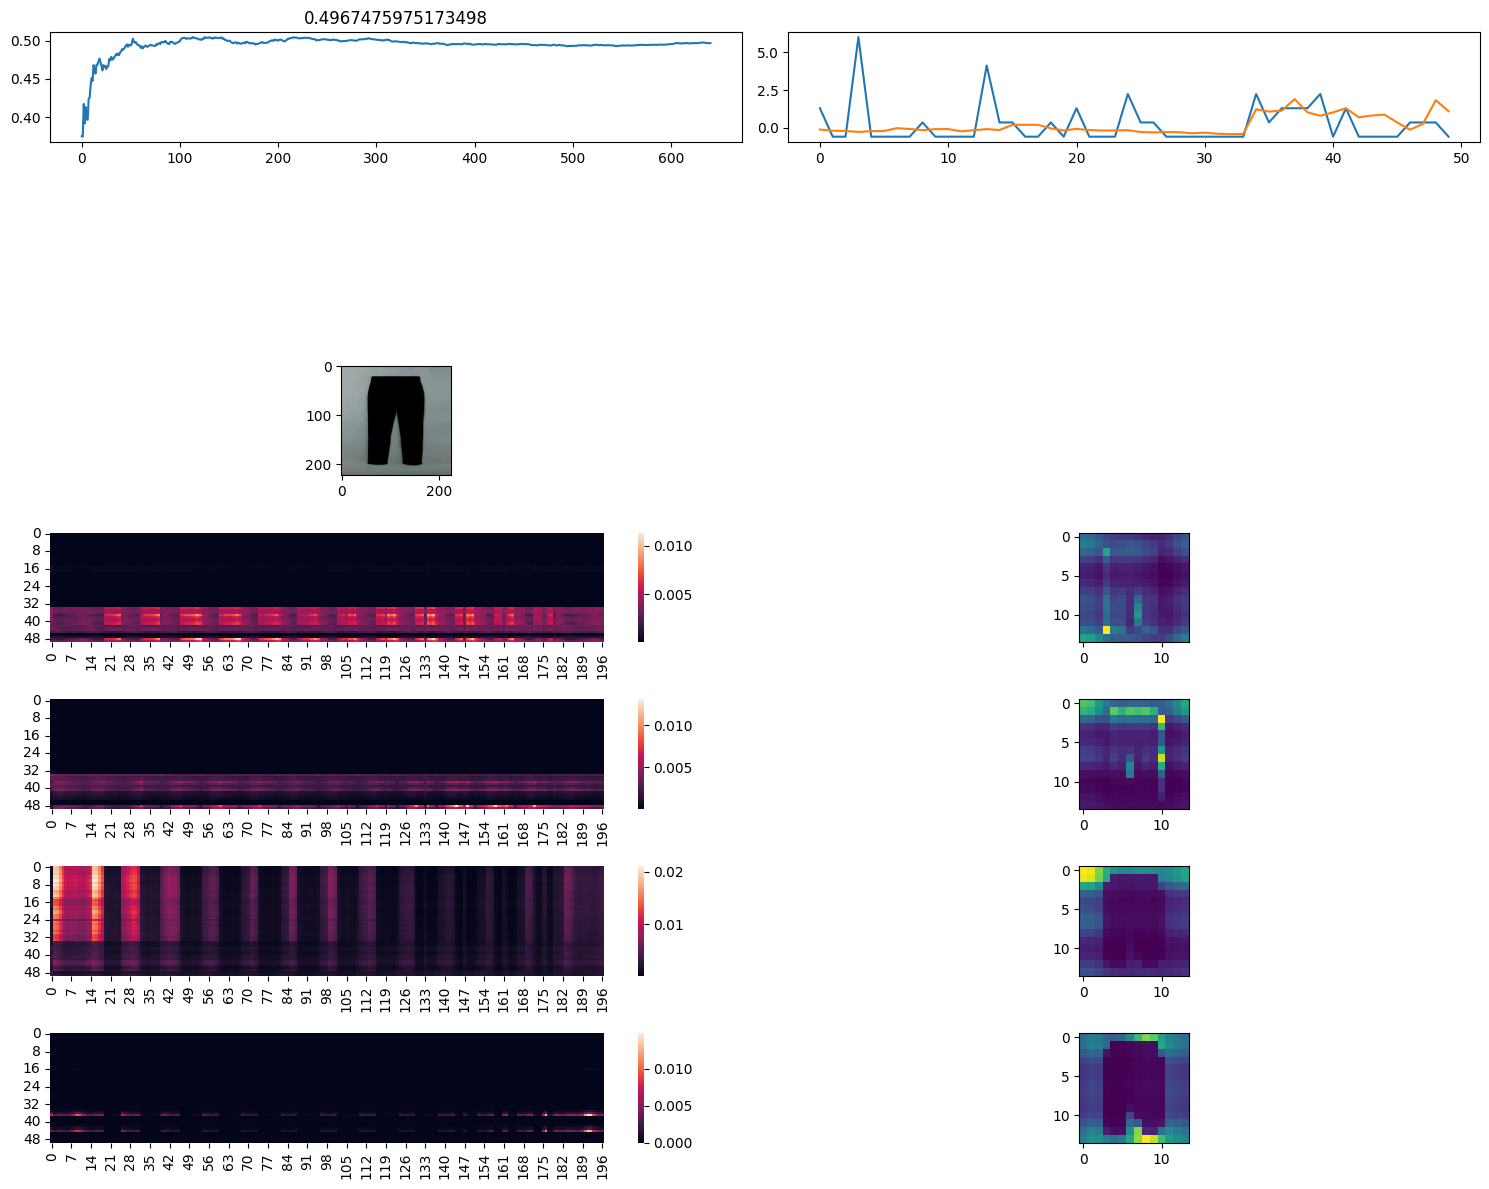

 35%|███▌      | 641/1830 [03:35<11:49,  1.68it/s]/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343962757/work/aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(
 35%|███▌      | 647/1830 [03:37<04:56,  3.99it/s]

In [ ]:
from tqdm import tqdm; tqdm.pandas()
from collections import defaultdict
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

mse_loss = torch.nn.MSELoss(reduction="none")
ce_loss = torch.nn.CrossEntropyLoss(reduction="none")

import copy

def train(e, model):
    pbar = tqdm(valid_dataloader)
    loss_li, mean_loss_li = [], []
    accm_idx = 0

    model.eval()
    for n, data in enumerate(pbar):
        # Train
        with torch.no_grad():
            output, self_attn_weight, cross_attn_weight_dict, data_dict, idx_dict, padding_mask_dict = model(copy.deepcopy(data), remain_rto, device)

        loss = mse_loss(output.squeeze(), data["sales"].to(device).squeeze())
        mask = torch.where((padding_mask_dict["temporal_padding_mask"].squeeze()==1)&(padding_mask_dict["target_fcst_mask"].squeeze()==0), 1, 0)

        loss *= mask
        loss = loss.sum() / mask.sum()
        loss_li.append(loss.item())
        mean_loss_li.append(np.array(loss_li).mean())

        # Plot
        if n % 20 == 0:
            nrows, ncols, idx = 30, 2, 0
            plt.figure(figsize=(15, 50))
            clear_output(wait=True)
            
            # Loss
            plt.subplot(nrows, ncols, 1)
            plt.plot(mean_loss_li)
            plt.title(mean_loss_li[-1])

            # Sample
            plt.subplot(nrows, ncols, 2)
            pred = torch.where(mask==1, output.squeeze(), torch.nan)[idx]
            pred = pred[~torch.isnan(pred)]
            y = torch.where(mask==1, data["sales"].to(device).squeeze(), torch.nan)[idx]
            y = y[~torch.isnan(y)]

            plt.plot(y.squeeze().detach().cpu())
            plt.plot(pred.squeeze().detach().cpu())

            # Cross attn weight
            plt.subplot(nrows, ncols, 5)
            plt.imshow(data_dict["img_path"].permute(0,2,3,1).detach().cpu()[idx])
            cross_attn_weight = cross_attn_weight_dict["temporal"].squeeze()

            plot_idx = 7
            for i in range(nhead):
                img_attn = cross_attn_weight[:, i, :, :]
                temporal_length = len(["global"] + data_info.modality_info["target"] + data_info.modality_info["temporal"])
                img_length = (224//patch_size)**2 + 1
                nlp_length = data_dict[data_info.modality_info["nlp"][0]].shape[-1] + data_dict[data_info.modality_info["nlp"][1]].shape[-1]
                # assert temporal_length + img_length + nlp_length == img_attn.shape[-1], f"{temporal_length} + {img_length} + {nlp_length} == {img_attn.shape}"
                
                ### Img                
                img_attn_weight = img_attn[:, :, temporal_length:temporal_length+img_length]
                img_attn_weight = torch.where(mask.unsqueeze(-1).repeat(1, 1, img_attn_weight.shape[-1])==1, img_attn_weight, torch.nan)
                img_attn_weight = img_attn_weight[idx]
                img_attn_weight = img_attn_weight[~torch.isnan(img_attn_weight)].reshape(-1, img_attn_weight.shape[-1])
                
                plt.subplot(nrows, ncols, plot_idx); plot_idx += 1
                sns.heatmap(img_attn_weight.detach().cpu())
                
                # img_attn_weight_seq_mean = img_attn_weight.mean(dim=0)[1:]
                img_attn_weight_seq_mean = img_attn_weight[0][1:]
                plt.subplot(nrows, ncols, plot_idx); plot_idx += 1
                img_attn_weight_seq_mean = img_attn_weight_seq_mean.reshape(224//patch_size,224//patch_size)
                plt.imshow(img_attn_weight_seq_mean.detach().cpu())

            plt.tight_layout()
            plt.show()

epoch = 10
for e in range(epoch):
    train(e, model)
    scheduler.step()
    # raise